### Stage5: Train our toy GPT model and generative Shakespeare-style texts 

#### (1) Import packages

In [3]:
import os,pickle,requests,time,math,torch,tiktoken,inspect
import numpy as np
from contextlib import nullcontext
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

#### (2) Define the GPT model

In [4]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)

        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None
        return logits, loss


    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")
        return optimizer

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True 

#### (3) Define the batch loader, loss estimator, and learning rate adjustor

In [5]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def get_lr(it):
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

#### (4) Configurate the training process

In [6]:
# NOTE: Configuration
dataset = 'shakespeare_char'
data_dir = os.path.join('../data', dataset)
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')

out_dir = '../out'
eval_interval = 200
eval_iters = 1
batch_size = 12
block_size = 64
learning_rate = 6e-4
max_iters = 5000
decay_lr = True
warmup_iters = 100
lr_decay_iters = max_iters
min_lr = learning_rate/10.0
tokens_per_iter = batch_size * block_size
local_iter_num = 0
running_mfu = -1.0
iter_num = 0
best_val_loss = 1e9
device = 'mps'
device_type = 'cpu'
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype='float16')

#### (5) Initialize the model and the optimizer

In [7]:
meta_path = os.path.join(data_dir, 'meta.pkl')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")
model_args = dict(n_layer=4, n_head=4, n_embd=128, block_size=block_size, bias=False, vocab_size=None, dropout=0.0) 
model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)
model.to(device)
scaler = torch.cuda.amp.GradScaler(enabled=False)
optimizer = model.configure_optimizers(1e-1, learning_rate, (0.9, 0.95), device_type)

found vocab_size = 65 (inside ../data/shakespeare_char/meta.pkl)
number of parameters: 0.80M
num decayed parameter tensors: 18, with 802,944 parameters
num non-decayed parameter tensors: 9, with 1,152 parameters
using fused AdamW: False


#### (6) The training process begins

In [8]:
loss_list = []
iter_list = []

if not os.path.exists(out_dir): 
    print("make dir=>{}".format(out_dir))
    os.makedirs(out_dir)
t0 = time.time()
X, Y = get_batch('train')
while True:
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    if iter_num == 0: 
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'model_args': model_args,
            'iter_num': iter_num,
            'best_val_loss': best_val_loss,
            }
        print(f"saving initial checkpoint to {out_dir}")
        torch.save(checkpoint, os.path.join(out_dir, 'ckpt_init.pt'))
    
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(iter_num % eval_interval)
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))

    #for micro_step in range(1):
    #with ctx:
    logits, loss = model(X, Y)
    loss = loss

    X, Y = get_batch('train')
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True)

    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % 1 == 0:
        lossf = loss.item()
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    
    loss_list.append(lossf)
    iter_list.append(iter_num)
    
    iter_num += 1
    local_iter_num += 1

    if iter_num > max_iters:
        break

saving initial checkpoint to ../out
0
step 0: train loss 4.1808, val loss 4.1848
iter 0: loss 4.1768, time 3659.01ms
iter 1: loss 4.1871, time 74.75ms
iter 2: loss 4.1799, time 25.91ms
iter 3: loss 4.1497, time 25.72ms
iter 4: loss 4.1339, time 27.67ms
iter 5: loss 4.0901, time 28.13ms
iter 6: loss 4.0629, time 27.39ms
iter 7: loss 4.0069, time 26.72ms
iter 8: loss 3.9654, time 25.27ms
iter 9: loss 3.9296, time 24.83ms
iter 10: loss 3.8833, time 25.08ms
iter 11: loss 3.8170, time 24.73ms
iter 12: loss 3.8028, time 27.12ms
iter 13: loss 3.7737, time 24.90ms
iter 14: loss 3.7643, time 27.89ms
iter 15: loss 3.7319, time 27.89ms
iter 16: loss 3.6857, time 24.69ms
iter 17: loss 3.7216, time 23.72ms
iter 18: loss 3.6653, time 23.86ms
iter 19: loss 3.6397, time 23.74ms
iter 20: loss 3.6795, time 26.37ms
iter 21: loss 3.6070, time 26.60ms
iter 22: loss 3.6449, time 28.09ms
iter 23: loss 3.6194, time 27.65ms
iter 24: loss 3.6178, time 26.76ms
iter 25: loss 3.5763, time 24.00ms
iter 26: loss 3.5

iter 232: loss 2.4890, time 28.89ms
iter 233: loss 2.4839, time 25.39ms
iter 234: loss 2.4514, time 25.09ms
iter 235: loss 2.5173, time 24.10ms
iter 236: loss 2.5349, time 25.17ms
iter 237: loss 2.5253, time 24.55ms
iter 238: loss 2.4532, time 26.68ms
iter 239: loss 2.5209, time 27.93ms
iter 240: loss 2.4870, time 25.88ms
iter 241: loss 2.5280, time 24.68ms
iter 242: loss 2.4425, time 23.89ms
iter 243: loss 2.5011, time 24.93ms
iter 244: loss 2.4153, time 24.58ms
iter 245: loss 2.5113, time 25.94ms
iter 246: loss 2.4461, time 25.80ms
iter 247: loss 2.4754, time 26.47ms
iter 248: loss 2.3999, time 24.67ms
iter 249: loss 2.4684, time 25.63ms
iter 250: loss 2.4883, time 25.72ms
iter 251: loss 2.4172, time 26.53ms
iter 252: loss 2.4752, time 27.14ms
iter 253: loss 2.3816, time 24.39ms
iter 254: loss 2.3600, time 23.89ms
iter 255: loss 2.5176, time 25.27ms
iter 256: loss 2.4942, time 24.80ms
iter 257: loss 2.4146, time 25.09ms
iter 258: loss 2.4928, time 26.29ms
iter 259: loss 2.5411, time 

iter 465: loss 2.2933, time 25.41ms
iter 466: loss 2.3810, time 25.44ms
iter 467: loss 2.3784, time 24.60ms
iter 468: loss 2.3243, time 27.88ms
iter 469: loss 2.1989, time 24.98ms
iter 470: loss 2.3415, time 27.40ms
iter 471: loss 2.4416, time 26.92ms
iter 472: loss 2.3042, time 29.08ms
iter 473: loss 2.4091, time 26.98ms
iter 474: loss 2.3433, time 27.67ms
iter 475: loss 2.3458, time 24.60ms
iter 476: loss 2.3149, time 26.17ms
iter 477: loss 2.3977, time 24.53ms
iter 478: loss 2.3696, time 25.56ms
iter 479: loss 2.3207, time 25.13ms
iter 480: loss 2.3485, time 27.34ms
iter 481: loss 2.3877, time 26.91ms
iter 482: loss 2.2739, time 26.20ms
iter 483: loss 2.4158, time 25.68ms
iter 484: loss 2.3019, time 28.21ms
iter 485: loss 2.3017, time 25.98ms
iter 486: loss 2.3218, time 24.80ms
iter 487: loss 2.4415, time 28.33ms
iter 488: loss 2.3199, time 26.64ms
iter 489: loss 2.2859, time 24.38ms
iter 490: loss 2.3613, time 24.29ms
iter 491: loss 2.3483, time 25.84ms
iter 492: loss 2.3627, time 

iter 699: loss 2.2790, time 25.68ms
iter 700: loss 2.2676, time 24.88ms
iter 701: loss 2.2796, time 28.51ms
iter 702: loss 2.3536, time 26.70ms
iter 703: loss 2.2312, time 25.89ms
iter 704: loss 2.3099, time 25.08ms
iter 705: loss 2.2766, time 25.31ms
iter 706: loss 2.2138, time 25.27ms
iter 707: loss 2.2189, time 25.21ms
iter 708: loss 2.3051, time 28.58ms
iter 709: loss 2.2985, time 25.64ms
iter 710: loss 2.2742, time 25.70ms
iter 711: loss 2.1955, time 26.11ms
iter 712: loss 2.1997, time 27.35ms
iter 713: loss 2.3342, time 29.08ms
iter 714: loss 2.2270, time 24.14ms
iter 715: loss 2.2501, time 25.19ms
iter 716: loss 2.2766, time 26.47ms
iter 717: loss 2.3012, time 27.15ms
iter 718: loss 2.1924, time 27.57ms
iter 719: loss 2.2372, time 26.86ms
iter 720: loss 2.3136, time 28.27ms
iter 721: loss 2.1583, time 28.13ms
iter 722: loss 2.2237, time 24.47ms
iter 723: loss 2.2431, time 24.90ms
iter 724: loss 2.1666, time 23.82ms
iter 725: loss 2.2913, time 25.75ms
iter 726: loss 2.1689, time 

iter 926: loss 2.1554, time 26.03ms
iter 927: loss 2.1400, time 28.62ms
iter 928: loss 2.1674, time 28.84ms
iter 929: loss 2.1793, time 24.57ms
iter 930: loss 2.1485, time 23.92ms
iter 931: loss 2.2154, time 23.77ms
iter 932: loss 2.1460, time 25.02ms
iter 933: loss 2.2047, time 24.93ms
iter 934: loss 2.2071, time 26.21ms
iter 935: loss 2.1895, time 24.83ms
iter 936: loss 2.0778, time 26.30ms
iter 937: loss 2.1309, time 24.56ms
iter 938: loss 2.2069, time 26.68ms
iter 939: loss 2.1646, time 25.95ms
iter 940: loss 2.1584, time 26.14ms
iter 941: loss 2.0766, time 25.13ms
iter 942: loss 2.1860, time 27.10ms
iter 943: loss 2.1710, time 26.76ms
iter 944: loss 2.1854, time 23.31ms
iter 945: loss 2.1682, time 23.64ms
iter 946: loss 2.3060, time 23.23ms
iter 947: loss 2.2127, time 23.82ms
iter 948: loss 2.1650, time 25.50ms
iter 949: loss 2.0289, time 25.57ms
iter 950: loss 2.1263, time 26.81ms
iter 951: loss 2.2128, time 26.77ms
iter 952: loss 2.1527, time 23.83ms
iter 953: loss 2.1774, time 

iter 1148: loss 2.0780, time 26.37ms
iter 1149: loss 2.1362, time 25.98ms
iter 1150: loss 2.0618, time 28.32ms
iter 1151: loss 2.1038, time 28.50ms
iter 1152: loss 2.0688, time 25.55ms
iter 1153: loss 2.1063, time 24.58ms
iter 1154: loss 2.0087, time 24.90ms
iter 1155: loss 2.0198, time 25.64ms
iter 1156: loss 2.1388, time 25.15ms
iter 1157: loss 1.9990, time 28.34ms
iter 1158: loss 2.0827, time 28.42ms
iter 1159: loss 2.0586, time 25.12ms
iter 1160: loss 2.1043, time 24.13ms
iter 1161: loss 2.0185, time 24.54ms
iter 1162: loss 2.1049, time 25.11ms
iter 1163: loss 2.2764, time 23.96ms
iter 1164: loss 2.0845, time 32.03ms
iter 1165: loss 2.1490, time 29.34ms
iter 1166: loss 2.0472, time 25.88ms
iter 1167: loss 2.0439, time 25.38ms
iter 1168: loss 2.0395, time 24.86ms
iter 1169: loss 2.0001, time 26.56ms
iter 1170: loss 2.0378, time 26.64ms
iter 1171: loss 2.0875, time 27.14ms
iter 1172: loss 1.9843, time 28.38ms
iter 1173: loss 2.0727, time 25.11ms
iter 1174: loss 2.0481, time 25.13ms
i

iter 1371: loss 2.0127, time 24.52ms
iter 1372: loss 1.9801, time 24.88ms
iter 1373: loss 2.1584, time 24.81ms
iter 1374: loss 1.9681, time 25.64ms
iter 1375: loss 2.0429, time 26.80ms
iter 1376: loss 1.9802, time 27.42ms
iter 1377: loss 2.0753, time 28.67ms
iter 1378: loss 1.9566, time 28.25ms
iter 1379: loss 2.0172, time 25.85ms
iter 1380: loss 2.0176, time 25.29ms
iter 1381: loss 1.9727, time 24.32ms
iter 1382: loss 2.0205, time 25.71ms
iter 1383: loss 2.0523, time 26.34ms
iter 1384: loss 2.0562, time 30.16ms
iter 1385: loss 1.9974, time 30.43ms
iter 1386: loss 1.9854, time 29.16ms
iter 1387: loss 1.9339, time 26.04ms
iter 1388: loss 1.9954, time 25.76ms
iter 1389: loss 1.9902, time 24.20ms
iter 1390: loss 1.9441, time 26.06ms
iter 1391: loss 1.9860, time 25.02ms
iter 1392: loss 2.0619, time 28.38ms
iter 1393: loss 1.9974, time 27.74ms
iter 1394: loss 1.9860, time 25.15ms
iter 1395: loss 1.9065, time 24.89ms
iter 1396: loss 2.0759, time 23.90ms
iter 1397: loss 2.0292, time 26.12ms
i

iter 1594: loss 2.0002, time 28.77ms
iter 1595: loss 1.8525, time 28.19ms
iter 1596: loss 1.9729, time 28.24ms
iter 1597: loss 2.0072, time 27.18ms
iter 1598: loss 1.9151, time 23.77ms
iter 1599: loss 1.8488, time 24.02ms
0
step 1600: train loss 1.9374, val loss 2.0092
saving checkpoint to ../out
iter 1600: loss 1.9907, time 60.41ms
iter 1601: loss 1.8811, time 27.78ms
iter 1602: loss 1.8393, time 27.76ms
iter 1603: loss 2.0080, time 27.51ms
iter 1604: loss 2.0132, time 26.68ms
iter 1605: loss 1.8879, time 23.77ms
iter 1606: loss 1.9737, time 25.00ms
iter 1607: loss 2.0883, time 24.30ms
iter 1608: loss 1.9199, time 25.26ms
iter 1609: loss 2.0928, time 25.18ms
iter 1610: loss 1.8893, time 29.14ms
iter 1611: loss 2.0176, time 25.62ms
iter 1612: loss 1.9328, time 26.40ms
iter 1613: loss 1.9563, time 26.81ms
iter 1614: loss 1.9113, time 27.50ms
iter 1615: loss 1.8365, time 27.27ms
iter 1616: loss 2.1050, time 23.73ms
iter 1617: loss 1.9417, time 24.15ms
iter 1618: loss 1.9332, time 24.70ms

iter 1817: loss 2.0177, time 25.15ms
iter 1818: loss 1.9427, time 27.05ms
iter 1819: loss 1.8031, time 26.28ms
iter 1820: loss 1.8921, time 27.02ms
iter 1821: loss 2.0816, time 26.84ms
iter 1822: loss 1.8407, time 23.97ms
iter 1823: loss 1.8749, time 23.61ms
iter 1824: loss 1.9256, time 24.07ms
iter 1825: loss 1.9909, time 24.76ms
iter 1826: loss 1.8760, time 26.41ms
iter 1827: loss 1.9119, time 25.97ms
iter 1828: loss 1.9146, time 24.91ms
iter 1829: loss 1.8706, time 26.13ms
iter 1830: loss 1.9014, time 25.42ms
iter 1831: loss 1.9536, time 26.80ms
iter 1832: loss 1.8564, time 24.32ms
iter 1833: loss 1.9728, time 24.40ms
iter 1834: loss 1.8842, time 24.85ms
iter 1835: loss 1.8757, time 24.60ms
iter 1836: loss 1.9294, time 24.63ms
iter 1837: loss 1.9176, time 26.38ms
iter 1838: loss 1.7859, time 25.30ms
iter 1839: loss 1.8427, time 26.11ms
iter 1840: loss 1.8598, time 26.32ms
iter 1841: loss 1.9517, time 29.39ms
iter 1842: loss 1.8761, time 28.89ms
iter 1843: loss 1.8546, time 24.38ms
i

iter 2045: loss 1.8390, time 25.35ms
iter 2046: loss 1.9196, time 27.59ms
iter 2047: loss 1.8808, time 27.17ms
iter 2048: loss 1.9319, time 23.69ms
iter 2049: loss 1.8651, time 25.76ms
iter 2050: loss 1.9269, time 23.69ms
iter 2051: loss 1.8826, time 24.10ms
iter 2052: loss 1.8902, time 25.00ms
iter 2053: loss 1.8265, time 25.94ms
iter 2054: loss 1.8469, time 27.01ms
iter 2055: loss 1.7451, time 27.38ms
iter 2056: loss 1.8639, time 25.28ms
iter 2057: loss 1.7759, time 24.04ms
iter 2058: loss 1.9090, time 24.12ms
iter 2059: loss 1.8663, time 24.79ms
iter 2060: loss 1.8509, time 24.75ms
iter 2061: loss 1.8284, time 27.38ms
iter 2062: loss 1.8545, time 24.65ms
iter 2063: loss 1.7803, time 26.33ms
iter 2064: loss 1.8793, time 26.68ms
iter 2065: loss 1.7273, time 24.72ms
iter 2066: loss 1.7993, time 25.56ms
iter 2067: loss 1.9792, time 24.39ms
iter 2068: loss 1.8734, time 23.81ms
iter 2069: loss 1.9005, time 25.12ms
iter 2070: loss 1.7853, time 25.31ms
iter 2071: loss 1.9504, time 27.32ms
i

iter 2268: loss 1.7802, time 27.50ms
iter 2269: loss 1.8020, time 28.57ms
iter 2270: loss 1.7923, time 26.99ms
iter 2271: loss 1.8487, time 26.94ms
iter 2272: loss 1.8176, time 25.43ms
iter 2273: loss 1.6965, time 28.46ms
iter 2274: loss 1.7862, time 28.74ms
iter 2275: loss 1.8036, time 26.14ms
iter 2276: loss 1.9123, time 25.12ms
iter 2277: loss 1.8869, time 25.36ms
iter 2278: loss 1.8814, time 27.91ms
iter 2279: loss 1.8727, time 28.64ms
iter 2280: loss 1.9414, time 29.15ms
iter 2281: loss 1.7462, time 29.05ms
iter 2282: loss 1.8172, time 29.45ms
iter 2283: loss 1.8175, time 27.56ms
iter 2284: loss 1.8794, time 26.64ms
iter 2285: loss 1.7171, time 25.46ms
iter 2286: loss 1.7794, time 27.77ms
iter 2287: loss 1.7278, time 25.18ms
iter 2288: loss 1.8236, time 28.58ms
iter 2289: loss 1.8914, time 28.88ms
iter 2290: loss 1.7476, time 36.29ms
iter 2291: loss 1.7087, time 28.01ms
iter 2292: loss 1.9512, time 28.61ms
iter 2293: loss 1.7559, time 29.86ms
iter 2294: loss 1.7791, time 27.61ms
i

iter 2491: loss 1.7760, time 28.13ms
iter 2492: loss 1.8677, time 27.78ms
iter 2493: loss 1.8105, time 25.42ms
iter 2494: loss 1.7318, time 24.69ms
iter 2495: loss 1.6858, time 24.71ms
iter 2496: loss 1.7356, time 25.12ms
iter 2497: loss 1.6729, time 25.33ms
iter 2498: loss 1.7168, time 27.06ms
iter 2499: loss 1.6862, time 27.08ms
iter 2500: loss 1.7285, time 26.05ms
iter 2501: loss 1.7010, time 25.38ms
iter 2502: loss 1.7562, time 25.40ms
iter 2503: loss 1.8081, time 27.33ms
iter 2504: loss 1.7516, time 26.26ms
iter 2505: loss 1.7298, time 28.55ms
iter 2506: loss 1.8089, time 28.32ms
iter 2507: loss 1.8176, time 26.62ms
iter 2508: loss 1.8149, time 24.72ms
iter 2509: loss 1.8028, time 25.28ms
iter 2510: loss 1.8697, time 24.61ms
iter 2511: loss 1.7481, time 24.73ms
iter 2512: loss 1.7693, time 27.51ms
iter 2513: loss 1.7959, time 30.04ms
iter 2514: loss 1.7386, time 25.03ms
iter 2515: loss 1.7710, time 24.86ms
iter 2516: loss 1.7782, time 24.99ms
iter 2517: loss 1.8385, time 26.60ms
i

iter 2714: loss 1.6992, time 25.99ms
iter 2715: loss 1.6918, time 24.61ms
iter 2716: loss 1.7644, time 28.00ms
iter 2717: loss 1.6899, time 25.66ms
iter 2718: loss 1.8457, time 30.10ms
iter 2719: loss 1.7957, time 29.13ms
iter 2720: loss 1.8051, time 34.51ms
iter 2721: loss 1.7332, time 25.01ms
iter 2722: loss 1.6269, time 27.68ms
iter 2723: loss 1.7611, time 24.67ms
iter 2724: loss 1.6503, time 27.63ms
iter 2725: loss 1.5976, time 30.13ms
iter 2726: loss 1.8119, time 32.14ms
iter 2727: loss 1.6769, time 26.67ms
iter 2728: loss 1.7023, time 25.55ms
iter 2729: loss 1.6582, time 27.44ms
iter 2730: loss 1.7473, time 28.75ms
iter 2731: loss 1.7899, time 27.91ms
iter 2732: loss 1.8336, time 29.42ms
iter 2733: loss 1.7554, time 29.56ms
iter 2734: loss 1.7711, time 24.75ms
iter 2735: loss 1.7611, time 25.14ms
iter 2736: loss 1.7907, time 25.50ms
iter 2737: loss 1.6341, time 28.64ms
iter 2738: loss 1.6914, time 30.41ms
iter 2739: loss 1.7873, time 26.51ms
iter 2740: loss 1.6706, time 27.20ms
i

iter 2939: loss 1.6668, time 24.75ms
iter 2940: loss 1.7644, time 28.97ms
iter 2941: loss 1.7650, time 24.73ms
iter 2942: loss 1.6876, time 24.21ms
iter 2943: loss 1.7468, time 23.69ms
iter 2944: loss 1.7086, time 24.16ms
iter 2945: loss 1.6519, time 28.01ms
iter 2946: loss 1.6962, time 26.10ms
iter 2947: loss 1.5842, time 29.89ms
iter 2948: loss 1.7963, time 24.21ms
iter 2949: loss 1.8038, time 29.26ms
iter 2950: loss 1.6932, time 25.82ms
iter 2951: loss 1.6453, time 24.79ms
iter 2952: loss 1.8427, time 27.38ms
iter 2953: loss 1.7290, time 25.87ms
iter 2954: loss 1.7529, time 28.19ms
iter 2955: loss 1.6457, time 27.15ms
iter 2956: loss 1.7994, time 25.67ms
iter 2957: loss 1.6055, time 23.82ms
iter 2958: loss 1.7002, time 24.60ms
iter 2959: loss 1.6928, time 24.23ms
iter 2960: loss 1.7460, time 25.79ms
iter 2961: loss 1.6863, time 27.70ms
iter 2962: loss 1.7467, time 24.85ms
iter 2963: loss 1.6045, time 28.09ms
iter 2964: loss 1.7503, time 25.08ms
iter 2965: loss 1.7422, time 26.11ms
i

iter 3165: loss 1.6186, time 28.31ms
iter 3166: loss 1.6208, time 28.84ms
iter 3167: loss 1.7162, time 24.01ms
iter 3168: loss 1.7327, time 25.24ms
iter 3169: loss 1.7115, time 23.83ms
iter 3170: loss 1.7850, time 26.03ms
iter 3171: loss 1.6131, time 25.68ms
iter 3172: loss 1.6945, time 28.56ms
iter 3173: loss 1.6713, time 25.70ms
iter 3174: loss 1.6852, time 24.49ms
iter 3175: loss 1.6337, time 24.43ms
iter 3176: loss 1.6270, time 25.56ms
iter 3177: loss 1.7170, time 27.89ms
iter 3178: loss 1.6011, time 30.98ms
iter 3179: loss 1.7826, time 29.07ms
iter 3180: loss 1.6970, time 31.60ms
iter 3181: loss 1.7267, time 30.34ms
iter 3182: loss 1.5349, time 26.99ms
iter 3183: loss 1.6836, time 25.38ms
iter 3184: loss 1.7639, time 26.11ms
iter 3185: loss 1.4995, time 25.23ms
iter 3186: loss 1.6203, time 26.87ms
iter 3187: loss 1.6129, time 26.59ms
iter 3188: loss 1.7060, time 28.74ms
iter 3189: loss 1.7068, time 32.67ms
iter 3190: loss 1.8017, time 28.29ms
iter 3191: loss 1.7582, time 28.57ms
i

iter 3390: loss 1.6803, time 24.83ms
iter 3391: loss 1.6845, time 24.21ms
iter 3392: loss 1.5985, time 25.11ms
iter 3393: loss 1.6502, time 26.94ms
iter 3394: loss 1.6631, time 31.40ms
iter 3395: loss 1.6464, time 29.71ms
iter 3396: loss 1.6482, time 28.65ms
iter 3397: loss 1.6887, time 25.56ms
iter 3398: loss 1.6925, time 24.66ms
iter 3399: loss 1.6197, time 24.05ms
0
step 3400: train loss 1.7287, val loss 1.9772
iter 3400: loss 1.6344, time 40.07ms
iter 3401: loss 1.7240, time 24.77ms
iter 3402: loss 1.6437, time 30.19ms
iter 3403: loss 1.5613, time 26.60ms
iter 3404: loss 1.6566, time 25.44ms
iter 3405: loss 1.6731, time 27.13ms
iter 3406: loss 1.7379, time 24.99ms
iter 3407: loss 1.6238, time 27.10ms
iter 3408: loss 1.7950, time 25.52ms
iter 3409: loss 1.6534, time 26.76ms
iter 3410: loss 1.7256, time 26.82ms
iter 3411: loss 1.7399, time 27.61ms
iter 3412: loss 1.8169, time 27.11ms
iter 3413: loss 1.5178, time 25.33ms
iter 3414: loss 1.5867, time 24.27ms
iter 3415: loss 1.6891, tim

iter 3615: loss 1.7078, time 25.60ms
iter 3616: loss 1.5588, time 26.52ms
iter 3617: loss 1.6322, time 24.29ms
iter 3618: loss 1.7838, time 25.31ms
iter 3619: loss 1.6506, time 26.85ms
iter 3620: loss 1.6810, time 27.71ms
iter 3621: loss 1.6042, time 26.17ms
iter 3622: loss 1.6334, time 25.90ms
iter 3623: loss 1.7163, time 24.51ms
iter 3624: loss 1.6642, time 24.70ms
iter 3625: loss 1.6514, time 23.90ms
iter 3626: loss 1.6298, time 26.98ms
iter 3627: loss 1.5592, time 26.56ms
iter 3628: loss 1.6411, time 23.46ms
iter 3629: loss 1.5759, time 24.40ms
iter 3630: loss 1.6824, time 25.31ms
iter 3631: loss 1.6497, time 24.98ms
iter 3632: loss 1.6347, time 25.28ms
iter 3633: loss 1.5204, time 26.14ms
iter 3634: loss 1.7573, time 26.87ms
iter 3635: loss 1.5245, time 26.74ms
iter 3636: loss 1.4982, time 23.62ms
iter 3637: loss 1.7279, time 23.42ms
iter 3638: loss 1.6223, time 23.17ms
iter 3639: loss 1.6541, time 23.70ms
iter 3640: loss 1.6509, time 25.78ms
iter 3641: loss 1.6495, time 26.24ms
i

iter 3842: loss 1.7471, time 24.53ms
iter 3843: loss 1.6005, time 24.27ms
iter 3844: loss 1.6433, time 25.08ms
iter 3845: loss 1.7573, time 24.48ms
iter 3846: loss 1.6521, time 26.39ms
iter 3847: loss 1.5766, time 25.19ms
iter 3848: loss 1.6648, time 28.08ms
iter 3849: loss 1.6477, time 26.98ms
iter 3850: loss 1.5874, time 24.24ms
iter 3851: loss 1.6515, time 24.65ms
iter 3852: loss 1.7539, time 23.74ms
iter 3853: loss 1.5983, time 23.91ms
iter 3854: loss 1.6562, time 24.50ms
iter 3855: loss 1.7333, time 29.95ms
iter 3856: loss 1.5481, time 28.37ms
iter 3857: loss 1.5441, time 28.26ms
iter 3858: loss 1.6394, time 31.82ms
iter 3859: loss 1.6133, time 25.30ms
iter 3860: loss 1.6723, time 24.67ms
iter 3861: loss 1.4904, time 23.91ms
iter 3862: loss 1.6176, time 24.11ms
iter 3863: loss 1.5886, time 24.65ms
iter 3864: loss 1.5945, time 29.39ms
iter 3865: loss 1.7930, time 27.96ms
iter 3866: loss 1.7258, time 24.52ms
iter 3867: loss 1.5514, time 24.21ms
iter 3868: loss 1.6328, time 23.57ms
i

iter 4066: loss 1.5119, time 28.38ms
iter 4067: loss 1.5862, time 26.07ms
iter 4068: loss 1.6195, time 26.19ms
iter 4069: loss 1.6339, time 25.84ms
iter 4070: loss 1.6289, time 25.17ms
iter 4071: loss 1.6859, time 24.03ms
iter 4072: loss 1.4842, time 27.17ms
iter 4073: loss 1.6687, time 28.46ms
iter 4074: loss 1.6609, time 23.78ms
iter 4075: loss 1.5672, time 25.05ms
iter 4076: loss 1.6258, time 25.60ms
iter 4077: loss 1.5980, time 26.43ms
iter 4078: loss 1.7244, time 25.22ms
iter 4079: loss 1.5640, time 27.64ms
iter 4080: loss 1.5984, time 25.10ms
iter 4081: loss 1.5372, time 24.58ms
iter 4082: loss 1.5118, time 25.18ms
iter 4083: loss 1.6792, time 24.84ms
iter 4084: loss 1.6305, time 24.81ms
iter 4085: loss 1.7361, time 26.04ms
iter 4086: loss 1.7503, time 25.81ms
iter 4087: loss 1.5710, time 26.49ms
iter 4088: loss 1.7324, time 28.17ms
iter 4089: loss 1.7403, time 23.50ms
iter 4090: loss 1.5023, time 24.66ms
iter 4091: loss 1.5342, time 23.65ms
iter 4092: loss 1.6109, time 24.23ms
i

iter 4292: loss 1.5373, time 27.37ms
iter 4293: loss 1.5564, time 25.84ms
iter 4294: loss 1.5833, time 27.02ms
iter 4295: loss 1.6134, time 25.41ms
iter 4296: loss 1.5502, time 26.63ms
iter 4297: loss 1.6111, time 27.50ms
iter 4298: loss 1.6727, time 24.58ms
iter 4299: loss 1.5797, time 24.61ms
iter 4300: loss 1.6013, time 24.27ms
iter 4301: loss 1.5269, time 24.69ms
iter 4302: loss 1.6922, time 25.03ms
iter 4303: loss 1.5186, time 29.60ms
iter 4304: loss 1.4841, time 24.55ms
iter 4305: loss 1.4334, time 27.04ms
iter 4306: loss 1.6452, time 26.20ms
iter 4307: loss 1.6673, time 24.76ms
iter 4308: loss 1.5983, time 24.89ms
iter 4309: loss 1.5904, time 24.93ms
iter 4310: loss 1.5275, time 23.85ms
iter 4311: loss 1.6731, time 25.65ms
iter 4312: loss 1.6309, time 29.22ms
iter 4313: loss 1.5689, time 27.61ms
iter 4314: loss 1.4604, time 28.19ms
iter 4315: loss 1.6835, time 26.63ms
iter 4316: loss 1.4266, time 23.82ms
iter 4317: loss 1.5471, time 24.02ms
iter 4318: loss 1.6228, time 25.08ms
i

iter 4517: loss 1.7325, time 27.58ms
iter 4518: loss 1.4829, time 28.94ms
iter 4519: loss 1.5765, time 24.05ms
iter 4520: loss 1.5671, time 24.78ms
iter 4521: loss 1.5736, time 23.30ms
iter 4522: loss 1.5263, time 24.54ms
iter 4523: loss 1.5042, time 25.75ms
iter 4524: loss 1.5266, time 26.41ms
iter 4525: loss 1.5253, time 25.48ms
iter 4526: loss 1.5408, time 27.90ms
iter 4527: loss 1.6021, time 25.28ms
iter 4528: loss 1.6635, time 26.84ms
iter 4529: loss 1.6383, time 26.45ms
iter 4530: loss 1.4982, time 23.36ms
iter 4531: loss 1.5138, time 25.56ms
iter 4532: loss 1.4885, time 24.48ms
iter 4533: loss 1.6466, time 24.16ms
iter 4534: loss 1.5279, time 25.37ms
iter 4535: loss 1.5660, time 25.19ms
iter 4536: loss 1.5525, time 25.53ms
iter 4537: loss 1.6640, time 27.74ms
iter 4538: loss 1.5471, time 27.13ms
iter 4539: loss 1.5159, time 29.77ms
iter 4540: loss 1.5496, time 28.15ms
iter 4541: loss 1.5919, time 26.19ms
iter 4542: loss 1.7137, time 24.76ms
iter 4543: loss 1.5269, time 24.24ms
i

iter 4738: loss 1.5992, time 26.91ms
iter 4739: loss 1.6795, time 26.78ms
iter 4740: loss 1.5258, time 27.01ms
iter 4741: loss 1.5207, time 26.59ms
iter 4742: loss 1.6402, time 24.01ms
iter 4743: loss 1.5675, time 23.16ms
iter 4744: loss 1.6839, time 23.42ms
iter 4745: loss 1.5715, time 24.03ms
iter 4746: loss 1.5079, time 24.72ms
iter 4747: loss 1.5795, time 26.19ms
iter 4748: loss 1.6175, time 27.24ms
iter 4749: loss 1.6024, time 27.35ms
iter 4750: loss 1.6502, time 24.29ms
iter 4751: loss 1.6446, time 23.74ms
iter 4752: loss 1.5994, time 23.84ms
iter 4753: loss 1.4773, time 25.25ms
iter 4754: loss 1.5790, time 25.13ms
iter 4755: loss 1.6364, time 27.43ms
iter 4756: loss 1.5532, time 25.79ms
iter 4757: loss 1.5930, time 27.03ms
iter 4758: loss 1.6707, time 26.96ms
iter 4759: loss 1.6905, time 24.03ms
iter 4760: loss 1.6489, time 25.39ms
iter 4761: loss 1.5985, time 23.93ms
iter 4762: loss 1.5716, time 24.62ms
iter 4763: loss 1.6353, time 25.82ms
iter 4764: loss 1.4945, time 27.41ms
i

iter 4964: loss 1.8301, time 26.45ms
iter 4965: loss 1.6496, time 26.01ms
iter 4966: loss 1.6247, time 29.58ms
iter 4967: loss 1.5344, time 27.10ms
iter 4968: loss 1.5400, time 27.28ms
iter 4969: loss 1.5094, time 27.41ms
iter 4970: loss 1.6734, time 27.46ms
iter 4971: loss 1.5190, time 24.26ms
iter 4972: loss 1.5851, time 25.57ms
iter 4973: loss 1.5643, time 26.41ms
iter 4974: loss 1.5721, time 25.86ms
iter 4975: loss 1.6804, time 25.84ms
iter 4976: loss 1.5791, time 28.11ms
iter 4977: loss 1.5186, time 27.79ms
iter 4978: loss 1.4892, time 28.87ms
iter 4979: loss 1.6754, time 25.48ms
iter 4980: loss 1.6419, time 25.76ms
iter 4981: loss 1.5954, time 25.74ms
iter 4982: loss 1.6235, time 26.45ms
iter 4983: loss 1.5885, time 27.62ms
iter 4984: loss 1.5401, time 27.75ms
iter 4985: loss 1.6361, time 27.45ms
iter 4986: loss 1.5307, time 23.97ms
iter 4987: loss 1.4931, time 24.24ms
iter 4988: loss 1.3924, time 24.25ms
iter 4989: loss 1.5767, time 24.25ms
iter 4990: loss 1.6003, time 27.24ms
i

#### (7) The figure about the loss during the training process

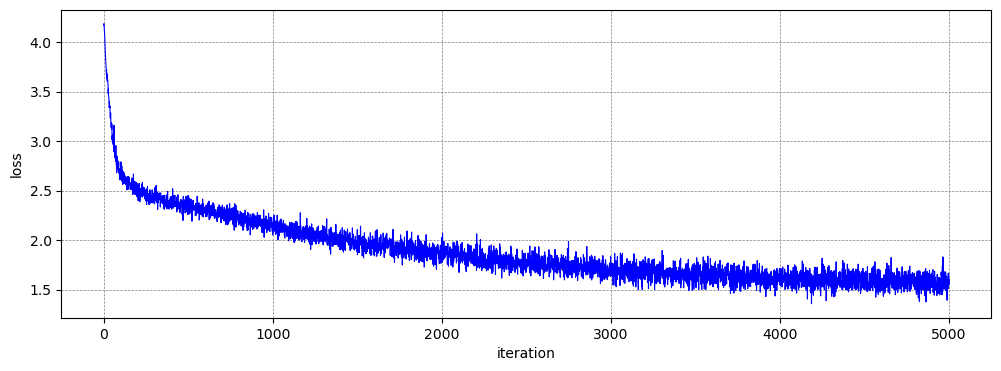

In [9]:
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rc('figure', figsize=(12, 4))
plt.plot(iter_list, loss_list,c="blue",linewidth=0.8)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.grid(axis='x', color='grey', linestyle='--', linewidth=0.5)
plt.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)
plt.show()

#### (8) Generate Shakespeare-style texts

In [10]:
start = "Shakespeare style \n"
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
# TODO want to make this more general to arbitrary encoder/decoder schemes
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

##### --> The results generated at iter=0

In [11]:
state_dict_init = torch.load("../out/ckpt_init.pt", map_location=device)['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict_init.items()):
    if k.startswith(unwanted_prefix):
        state_dict_init[k[len(unwanted_prefix):]] = state_dict_init.pop(k)
model.load_state_dict(state_dict_init)
with torch.no_grad():
        y = model.generate(x, 500, temperature=0.8, top_k=200)
        print('------------------------')
        print(decode(y[0].tolist()))
        print('------------------------')

------------------------
Shakespeare style 
VufmpQXCkXt,g&wwwPPuUkowX:MQT&,PA:kvFFZzZvc.VfwVbwN'xCjKCctJY-;;ImtAvSHhrm-FZPxxRGa'PMVkhha,icSH BwRlCzo&irYlr&DgMA!RxUujRwjZB-lAd'tGxtV:OW.QrtvVS:qPm!bdaRIC3KjMAnl-yAR&Jt3j'N3JWxCZvjCCYUqgsO?hhH &DtD:XkIw3Yxss-jN&Hc;lzlNqBHn!MqaXRRo;w!d-qnjZZBIV:bKjEM3$ttEY
zW-SI-ffxS!'GBctC.r.uyYFBgvzOBY;;fU!f?!yeCZJlSw!Vbsp-CCSpNtyNlfnsPVxImxbcQkwvN P-?w$$JufK ::rBa;Dp-SuLMllO UF
CRPGLQFAab,fBVPRpp.kcVB3Cw KnZVNDyH HSdW'd;xgi:$zTOu gpqdQ:Jjqs3HTK;MZmVgjAh,nkkY;VPLOJa??sjyDr
vJ?f;:l'GLiS&WW?gg;ECww
tBvwz,O VAq
------------------------


##### --> The results generated at iter=5000

In [12]:
state_dict = torch.load("../out/ckpt.pt", map_location=device)['model']
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
with torch.no_grad():
        y = model.generate(x, 500, temperature=0.8, top_k=200)
        print('------------------------')
        print(decode(y[0].tolist()))
        print('------------------------')

------------------------
Shakespeare style 
For down him be freet, sond against: what is stome?
Mick it remed
With wors in this neir bornesse quines her.

BANTHROLAND:
Now, my shame and in to be be so: I was that?
You, or for womand for the shall my wrother!

Secrvice speptt on me of I things for these before.

JOHN ERGOKEIND:
I come than therefore: be for sold be in the had;
And the are the for he great thee cantagen,
To all your at our caporse and this reselvess.

MENCUSdame.


CARIOLA:
Ay, 'Twither seak we stones well. Suse's he I
Firs
------------------------
